# Growing population

Even though the original paper predicts that as population size increases, the chance of resorting to only pheromone recruitment increases, we do not see this in the HDMR sobol analysis. One potential key-factor we left out in the current implementation is that population size is NOT static. An ant colony is expected to grow over time. Therefore we added the option for colonies to grow. In this notebook we explore the effect of adding one unassigned ant each timestep.

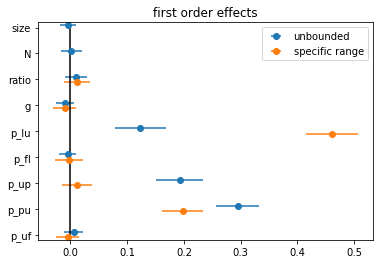

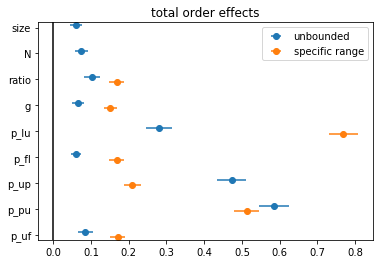

In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from plot import plot_param_var_conf
from model import Environment
from batchrunner import BatchRunner

In [2]:
# Run a batch, which can either grow or not
param_names = ['grow']
param_sets = [(True, ), (False, )]
fixed_params = {'p_uf': 0.95, 'p_pu': 0.1, 'p_up': 0.5, 'p_fl': 0.8, 'p_lu': 0.05, 'g': 0.3, 'ratio': 0.48, 'size': 11, 'N': 40}

model_reporters = {"dc": lambda m: m.dc.model_vars}
batch = BatchRunner(Environment,
                    fixed_parameters=fixed_params, max_steps=500,
                    iterations=100, model_reporters=model_reporters,
                    param_sets=param_sets, param_names=param_names)

batch.run_all(6)
data = batch.get_model_vars_dataframe()

100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


In [3]:
# Now extract the interesting params (in an extremely inefficient manner)
grown = data[data['grow'] == True]
stead = data[data['grow'] == False]
stead_vals = pd.DataFrame(columns=['time', 'pu_net', 'flu_net'])
grown_vals = pd.DataFrame(columns=['time', 'pu_net', 'flu_net'])

for run in stead['dc'].values:
    for i in range(len(run['pheromone'])):
        total = run['pheromone'][i] + run['leaders'][i] + run['followers'][i] + run['unassigned'][i]
        stead_vals = stead_vals.append(pd.Series([i, (run['pheromone'][i] - run['unassigned'][i])/total, (run['followers'][i] + run['leaders'][i] - run['unassigned'][i])/total], index=['time', 'pu_net', 'flu_net']), ignore_index=True)

for run in grown['dc'].values:
    for i in range(len(run['pheromone'])):
        total = run['pheromone'][i] + run['leaders'][i] + run['followers'][i] + run['unassigned'][i]
        grown_vals = grown_vals.append(pd.Series([i, (run['pheromone'][i] - run['unassigned'][i])/total, (run['followers'][i] + run['leaders'][i] - run['unassigned'][i])/total], index=['time', 'pu_net', 'flu_net']), ignore_index=True)

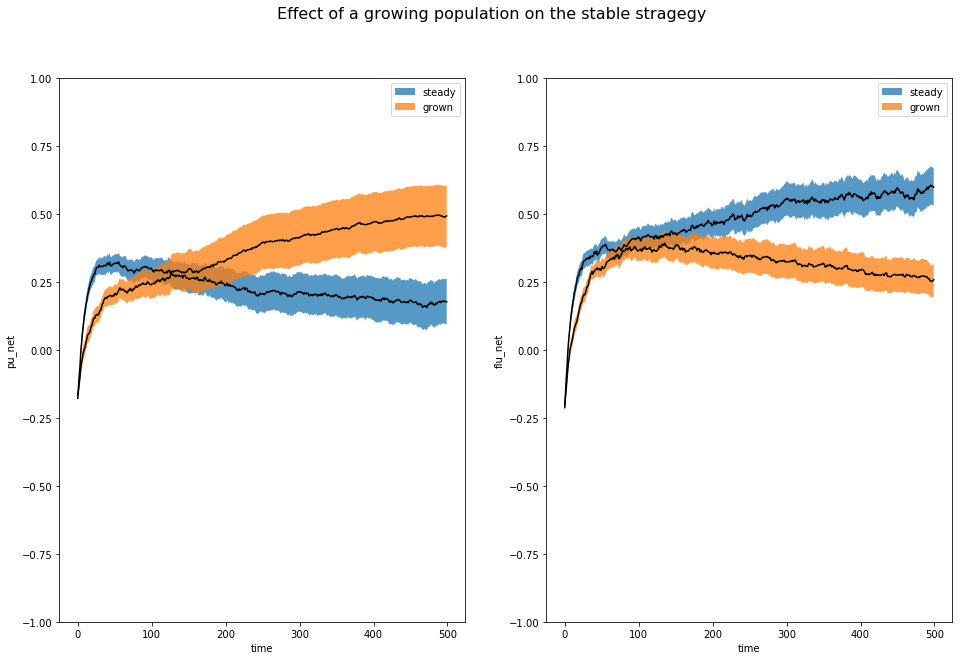

In [4]:
# Show the results
fig = plt.figure(figsize=(16, 10))
plt.suptitle('Effect of a growing population on the stable strategy', fontsize=16)

ax1 = fig.add_subplot(1, 2, 1)
plot_param_var_conf(ax1, stead_vals, 'time', 'pu_net', label='steady', alpha=0.75)
plot_param_var_conf(ax1, grown_vals, 'time', 'pu_net', label='grown', alpha=0.75)
plt.legend()
plt.ylim([-1, 1])

ax2 = fig.add_subplot(1, 2, 2)
plot_param_var_conf(ax2, stead_vals, 'time', 'flu_net', label='steady', alpha=0.75)
plot_param_var_conf(ax2, grown_vals, 'time', 'flu_net', label='grown', alpha=0.75)
plt.legend()
plt.ylim([-1, 1])

plt.show()

In the plot we see the 95% confidence intervals for some data descriptions for 100 replicates over grow or not. There is a clear distinction between whether the population size is static or not, and we can easily confirm that colonies tend more towards pheromone recruitment as their size increases.